In [1]:
import os
import sys
import glob
import time

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
# 乱数シードを固定
np.random.seed(1234)
torch.manual_seed(1234)

## Simple Two-Layer NN

In [4]:
def func(x):
    noise = 0.2 * np.random.rand(x.shape[0]) - 0.1
    t = x + 0.3 * np.sin(2*np.pi*x) + noise
    return t    

In [5]:
x_list = np.random.rand(100)
t_list = func(x_list)

In [6]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.tanh(x)
        x = self.output(x)
        return x

In [7]:
x2t_model = TwoLayerNN(1,6,1)
t2x_model = TwoLayerNN(1,6,1)

In [8]:
learning_rate = 0.01
num_epochs = 10000
criterion = nn.MSELoss()

In [9]:
for i, model in enumerate([x2t_model, t2x_model]):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # トレーニングループ
    for j, epoch in enumerate(range(num_epochs)):

        if i==0:
            inputs = torch.Tensor(x_list).unsqueeze(-1)
            true_list = torch.Tensor(t_list).unsqueeze(-1)
        else:
            inputs = torch.Tensor(t_list).unsqueeze(-1)
            true_list = torch.Tensor(x_list).unsqueeze(-1)

        pred_t_list = model(inputs)
        loss = criterion(pred_t_list, true_list)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if j % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10000], Loss: 1.0448
Epoch [101/10000], Loss: 0.0202
Epoch [201/10000], Loss: 0.0202
Epoch [301/10000], Loss: 0.0201
Epoch [401/10000], Loss: 0.0201
Epoch [501/10000], Loss: 0.0201
Epoch [601/10000], Loss: 0.0200
Epoch [701/10000], Loss: 0.0200
Epoch [801/10000], Loss: 0.0200
Epoch [901/10000], Loss: 0.0199
Epoch [1001/10000], Loss: 0.0199
Epoch [1101/10000], Loss: 0.0199
Epoch [1201/10000], Loss: 0.0198
Epoch [1301/10000], Loss: 0.0198
Epoch [1401/10000], Loss: 0.0197
Epoch [1501/10000], Loss: 0.0197
Epoch [1601/10000], Loss: 0.0196
Epoch [1701/10000], Loss: 0.0194
Epoch [1801/10000], Loss: 0.0192
Epoch [1901/10000], Loss: 0.0188
Epoch [2001/10000], Loss: 0.0180
Epoch [2101/10000], Loss: 0.0161
Epoch [2201/10000], Loss: 0.0113
Epoch [2301/10000], Loss: 0.0049
Epoch [2401/10000], Loss: 0.0033
Epoch [2501/10000], Loss: 0.0033
Epoch [2601/10000], Loss: 0.0033
Epoch [2701/10000], Loss: 0.0033
Epoch [2801/10000], Loss: 0.0033
Epoch [2901/10000], Loss: 0.0033
Epoch [3001/10000], Lo

In [10]:
out_list = []
grid_values = torch.Tensor(np.linspace(0, 1, 100))
for i, model in enumerate([x2t_model, t2x_model]):

    with torch.no_grad():

        test_inputs = grid_values.unsqueeze(-1)
        test_outputs = model(test_inputs)

    out_list.append(test_outputs)

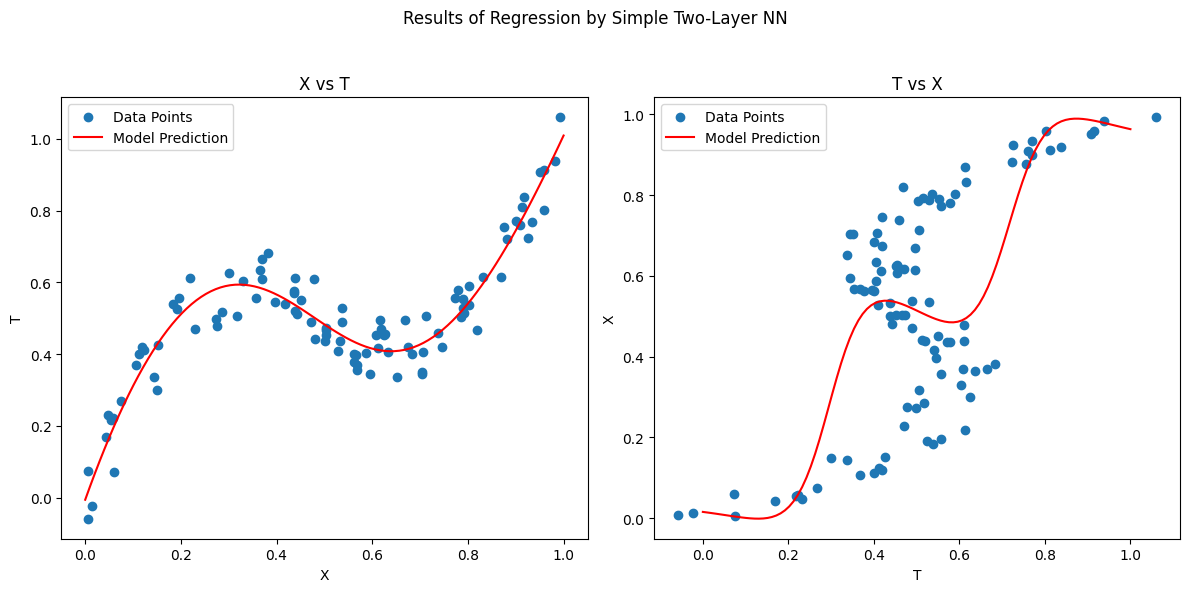

In [11]:
# Set up the figure
plt.figure(figsize=(12, 6))
plt.suptitle('Results of Regression by Simple Two-Layer NN')

# First subplot
ax1 = plt.subplot(1, 2, 1)
plt.scatter(x_list, t_list, label='Data Points')
plt.plot(grid_values, out_list[0], color='red', label='Model Prediction')
plt.title('X vs T')
plt.xlabel('X')
plt.ylabel('T')
plt.legend()

# Second subplot
ax2 = plt.subplot(1, 2, 2)
plt.scatter(t_list, x_list, label='Data Points')
plt.plot(grid_values, out_list[1], color='red', label='Model Prediction')
plt.title('T vs X')
plt.xlabel('T')
plt.ylabel('X')
plt.legend()

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Mixture density network

In [12]:
class MixtureDensityNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_elements):
        super(MixtureDensityNetwork, self).__init__()
        self.n_elements = n_elements
        self.output_size = output_size
        self._delta = self.output_size + 2
        self.hidden = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_size, n_elements * self._delta)
        
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.tanh(x)
        x = self.output(x)
        mu = x[:, :self._delta * 1]
        sigma = torch.exp(x[:, self._delta * 1:self._delta * 2])
        pi = torch.softmax(x[:, self._delta * 2:self._delta * 3], dim=1)
        return mu, sigma, pi

In [13]:
def mdn_loss(y_true, mu, sigma, pi):
    # print(f"mu.shape:{mu.shape}")
    # print(f"sigma.shape:{sigma.shape}")
    dist = torch.distributions.Normal(loc=mu, scale=sigma)
    probs = torch.exp(dist.log_prob(y_true))
    # print(f"probs.shape:{probs.shape}")
    weighted_probs = pi * probs
    # print(f"weighted_probs.shape:{weighted_probs.shape}")
    loss = - torch.log(torch.sum(weighted_probs, dim=1))
    # print(f"loss.shape:{loss.shape}")
    return torch.mean(loss)

In [14]:
model = MixtureDensityNetwork(1,6,1,3)

In [15]:
learning_rate = 0.01
num_epochs = 5000
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
for i, epoch in enumerate(range(num_epochs)):

    inputs = torch.Tensor(t_list).unsqueeze(-1)
    true_list = torch.Tensor(x_list).unsqueeze(-1)

    mu, sigma, pi = model(inputs)
    loss = mdn_loss(true_list, mu, sigma, pi)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5000], Loss: 0.7641
Epoch [101/5000], Loss: -0.5884
Epoch [201/5000], Loss: -0.9476
Epoch [301/5000], Loss: -1.0333
Epoch [401/5000], Loss: -1.0424
Epoch [501/5000], Loss: -1.0453
Epoch [601/5000], Loss: -1.0474
Epoch [701/5000], Loss: -1.0511
Epoch [801/5000], Loss: -1.0533
Epoch [901/5000], Loss: -1.0526
Epoch [1001/5000], Loss: -1.0589
Epoch [1101/5000], Loss: -1.0612
Epoch [1201/5000], Loss: -1.0636
Epoch [1301/5000], Loss: -1.0653
Epoch [1401/5000], Loss: -1.0675
Epoch [1501/5000], Loss: -1.0692
Epoch [1601/5000], Loss: -1.0691
Epoch [1701/5000], Loss: -1.0696
Epoch [1801/5000], Loss: -1.0728
Epoch [1901/5000], Loss: -1.0739
Epoch [2001/5000], Loss: -1.0746
Epoch [2101/5000], Loss: -1.0756
Epoch [2201/5000], Loss: -1.0762
Epoch [2301/5000], Loss: -1.0573
Epoch [2401/5000], Loss: -1.0775
Epoch [2501/5000], Loss: -1.0774
Epoch [2601/5000], Loss: -1.0786
Epoch [2701/5000], Loss: -1.0777
Epoch [2801/5000], Loss: -1.0796
Epoch [2901/5000], Loss: -1.0799
Epoch [3001/5000], Loss

In [17]:
with torch.no_grad():
    test_inputs = torch.Tensor(grid_values).unsqueeze(-1)
    mu, sigma, pi = model(test_inputs)

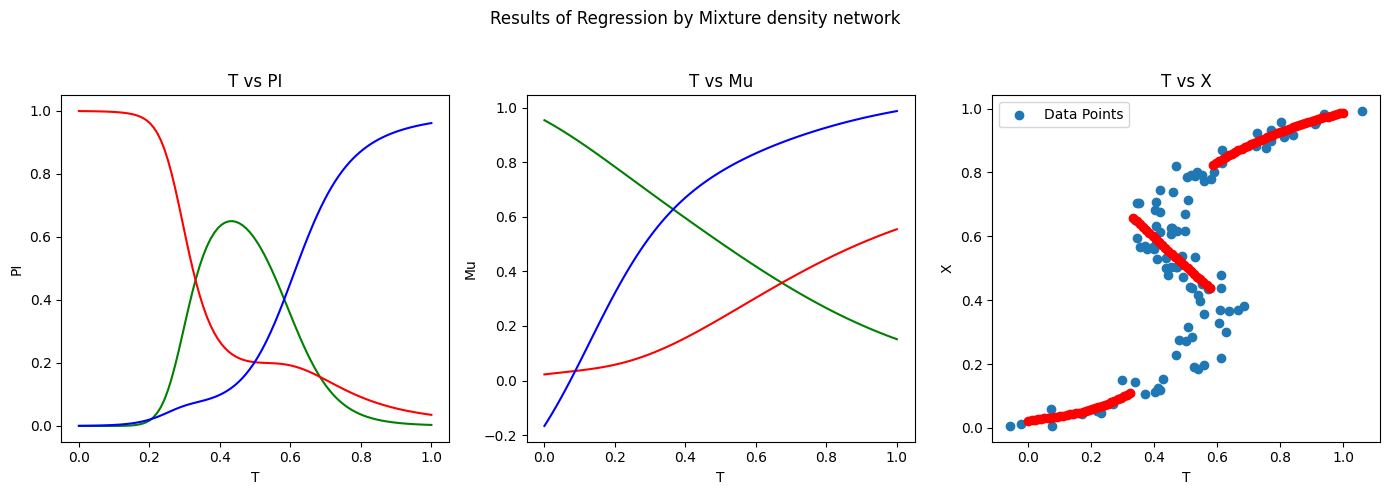

In [18]:
# Set up the figure
plt.figure(figsize=(14, 5))
plt.suptitle('Results of Regression by Mixture density network')

ax1 = plt.subplot(1, 3, 1)
plt.plot(grid_values, pi[:,0], color='green')
plt.plot(grid_values, pi[:,1], color='red')
plt.plot(grid_values, pi[:,2], color='blue')
plt.title('T vs PI')
plt.xlabel('T')
plt.ylabel('PI')

ax2 = plt.subplot(1, 3, 2)
plt.plot(grid_values, mu[:,0], color='green')
plt.plot(grid_values, mu[:,1], color='red')
plt.plot(grid_values, mu[:,2], color='blue')
plt.title('T vs Mu')
plt.xlabel('T')
plt.ylabel('Mu')

ax3 = plt.subplot(1, 3, 3)
plt.scatter(t_list, x_list, label='Data Points')
plt.scatter(grid_values, mu.gather(1, pi.argmax(dim=1).unsqueeze(1)), color='red')
plt.title('T vs X')
plt.xlabel('T')
plt.ylabel('X')
plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()